# Quotes classification

In this notebook, we treat each quote of the corpus and assign them a binary score determining if the quote is formal or colloquial according the dictionnary of english contractions to avoid in wikipedia articles

## Packages and functions

In [17]:
#packages
import pandas as pd
from tqdm import tqdm, notebook
notebook.tqdm().pandas()

0it [00:00, ?it/s]

In [18]:
#function to check if strin is contained and update dico
def isinside1(test_string,test_list):
    global dico
    res = [ele for ele in test_list if(ele in test_string)]
    #print(res)
    if res:
        for ele in res:
            i= test_list.index(ele)
            dico["occurences"].loc[i]= dico["occurences"].loc[i]+1
        return 1
    return 0

def isinside2(test_string,test_list):
    if any(ext in test_string for ext in test_list):
        return 1
    return 0

## Dictionnary loading
The dictionnary is compiled in the notebook `contractions_dictionary.ipynb` and is based on the [Wikipedia English contractions list](https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions).<br>
A column name "occurences" is created in order to count how much time a word is detected.<br>
A list is made from the dictionary words for comparison

In [19]:
dico= pd.read_pickle("./english_contractions.pkl")
dico["occurences"]=0
dicolist= dico["word"].unique().tolist()

## Quotebank sample loading

In [20]:
df= pd.read_json("../../../Sample_classified_1Mio_v1.json.bz2",compression="bz2",lines=True)
#df= pd.read_json("../../../polUS_quotes_speakers_merged.json.bz2",compression="bz2",lines=True)

### Quotes formatting for comparison : lowercase and space at the beginning and end
Note that tokenisation has not been used as some of the words or the dictionary consist in several tokens (for exemple, isn't is composed of tokens "is" and "n't"

In [21]:
df_tested_quotes= df["quotation"].progress_apply(lambda x : " "+x.lower()+" ")

  0%|          | 0/668534 [00:00<?, ?it/s]

## Classification using the full dictionary
The dataset quotes are classified a first time using the full dictionary

### Classifying

In [22]:
df["colloquial"]= df_tested_quotes.progress_apply(lambda x : isinside1(x,dicolist))

  0%|          | 0/668534 [00:00<?, ?it/s]

/Users/nicolasantacroce/opt/anaconda3/envs/adaenv/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### Quotes statistics

In [23]:
df.describe()

numOccurrences             p1             p2        delta_p  \
count    668534.00000  668534.000000  668534.000000  668534.000000   
mean          3.55898       0.818245       0.161096       0.657149   
std          22.64603       0.095738       0.081709       0.173361   
min           1.00000       0.500100       0.008600       0.300000   
25%           1.00000       0.747400       0.093400       0.521900   
50%           1.00000       0.830100       0.152600       0.674900   
75%           2.00000       0.897300       0.221900       0.802200   
max       12086.00000       0.990800       0.350000       0.982100   

                year     colloquial  
count  668534.000000  668534.000000  
mean     2017.536327       0.383233  
std         1.770882       0.486175  
min      2015.000000       0.000000  
25%      2016.000000       0.000000  
50%      2018.000000       0.000000  
75%      2019.000000       1.000000  
max      2020.000000       1.000000

About 38.3% of quotes are qualified as colloquial.

### Most common words

In [24]:
dico["occurence_fraction"]= dico["occurences"]/df["colloquial"].count()
dico.sort_values(by='occurence_fraction', ascending=False)[:25]

word  occurences  occurence_fraction
63        it's        68314            0.102185
19       don't        32580            0.048733
54         i'm        32185            0.048143
102     that's        28226            0.042221
129      we're        26724            0.039974
42        he's        17141            0.025640
107    there's        14634            0.021890
130      we've        14475            0.021652
59        i've        13896            0.020786
17      didn't        12503            0.018702
6        can't        11439            0.017111
174     you're        10881            0.016276
112    they're        10873            0.016264
18     doesn't         7385            0.011047
128      we'll         6610            0.009887
125     wasn't         5208            0.007790
49         i'd         4148            0.006205
53        i'll         4109            0.006146
136     what's         3986            0.005962
175     you've         3624            0.005421
159      won't         3467            0.005186
38     haven't         3441            0.005147
11    couldn't         3381            0.005057
113    they've         3332            0.004984
90       she's         3124            0.004673

<AxesSubplot:title={'center':'Word occurences (log-log)'}, xlabel='word rank', ylabel='# of word occurences'>

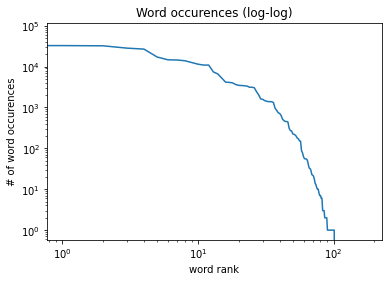

In [25]:
dico.sort_values(by='occurence_fraction', ascending=False).reset_index()["occurences"].plot(
    xlabel="word rank", ylabel= "# of word occurences", title= "Word occurences (log-log)",logy=True, logx=True)

Surprisingly, words use do not seem to follow a zipf law (the line would be straight if it was the case)

## Classification using the reduced dictionary
The dataset quotes are classified again using a dictionary from which the most common words have been removed

### Removal of word that appear in more than a certain fraction of words defined in the thresh variable

In [26]:
tresh= 0.02
dico2= dico[dico["occurence_fraction"]<tresh]
dicolist2= dico2["word"].unique().tolist()

### Classifying

In [27]:
df["colloquial"]= df_tested_quotes.progress_apply(lambda x : isinside2(x.lower(),dicolist2))

  0%|          | 0/668534 [00:00<?, ?it/s]

### Quotes statistics

In [28]:
df.describe()

numOccurrences             p1             p2        delta_p  \
count    668534.00000  668534.000000  668534.000000  668534.000000   
mean          3.55898       0.818245       0.161096       0.657149   
std          22.64603       0.095738       0.081709       0.173361   
min           1.00000       0.500100       0.008600       0.300000   
25%           1.00000       0.747400       0.093400       0.521900   
50%           1.00000       0.830100       0.152600       0.674900   
75%           2.00000       0.897300       0.221900       0.802200   
max       12086.00000       0.990800       0.350000       0.982100   

                year     colloquial  
count  668534.000000  668534.000000  
mean     2017.536327       0.164206  
std         1.770882       0.370462  
min      2015.000000       0.000000  
25%      2016.000000       0.000000  
50%      2018.000000       0.000000  
75%      2019.000000       0.000000  
max      2020.000000       1.000000

We now have 10.2% of colloquial quotes

## Quotes classification examples

In [29]:
import random
df_formal= df[df["colloquial"]==0].reset_index()
df_colloquial= df[df["colloquial"]==1].reset_index()

print("5 formal quotes sample : ")
for i in random.sample(range(len(df_formal)), 5):
    print("\n")
    print(df_formal["quotation"].loc[i])

print("\n5 colloquial quotes sample : ")
for i in random.sample(range(len(df_colloquial)), 5):
    print("\n")
    print(df_colloquial["quotation"].loc[i])

5 formal quotes sample : 


Our trials showed that moving dry cows to fresh pasture regularly reduced the rate of infection from one in three to one in ten.


I want to thank the community for continuing to raise their concerns about this issue so that we can properly address them,


I don't take part in any competition just for the sake of it. My aim is to win and that too convincingly,


The Federal Government of Nigeria needs to know that our youths are losing confidence in the peaceful and non-violent way we are proposing. And I will like to state clearly that today, out of respect for Archbishop Anthony Obinna, who has been foremost in speaking out in defence of good governance both in his state and in the country, that the current Federal Government of Nigeria will hold itself responsible if it refuses to listen to the voice of reason and the calamity we all fear will befall our dear country.


We have dropped more points than we would have liked. But we can only look at the next

## Larger samples classification

In [30]:
del df
for year in range(2019,2020):
    print("start")
    sample= pd.read_json("../../../large_sample/Sample_{}_wrangled.json.bz2".format(year)
                         ,compression="bz2",lines=True)
    print("opened sample {}".format(year))
    sample_lowercase_quotes= sample["quotation"].progress_apply(lambda x : " "+x.lower()+" ")
    print("lowercased sample")
    sample["colloquial"]= sample_lowercase_quotes.progress_apply(lambda x : isinside2(x.lower(),dicolist2))
    print("classified sample")
    sample.to_json("../../../large_sample/Sample_{}_classified.json.bz2".format(year)
                   ,compression='bz2',lines=True,orient="records")
    print("saved sample")
    del sample

start
opened sample 2019


  0%|          | 0/1660942 [00:00<?, ?it/s]

lowercased sample


  0%|          | 0/1660942 [00:00<?, ?it/s]

classified sample
saved sample
